In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

df = pd.read_json('../data/database-10-12.json')

In [9]:
df['content_length'] = df['content'].str.len()
df['content_words'] = df['content'].str.split().map(len)

#### Füge ein neues Feature hinzu: Themengebiet

In [10]:
topics = json.loads(open("topics/topics.json", "r").read())

df['tags_full'] = ['; '.join(tags) for tags in df['tags'].to_list()]

for topic in topics:
    df.loc[(df.title.str.contains('|'.join(topics[topic]['keywords'])) | df.tags_full.str.contains('|'.join(topics[topic]['keywords']))), 'topic'] = topic

## Gruppiere die Artikel nach: Themengebiet
#### Aggregiere pro Themengebiet die Durchschnittsanzahl Wörter/Zeichen

In [11]:
df = df.groupby(['topic']).agg({"content_length": "mean", "content_words": "mean"})

#### Sortiere die Artikel nach: Anzahl Zeichen (absteigend)

In [12]:
df = df.sort_values("content_length", ascending=False)

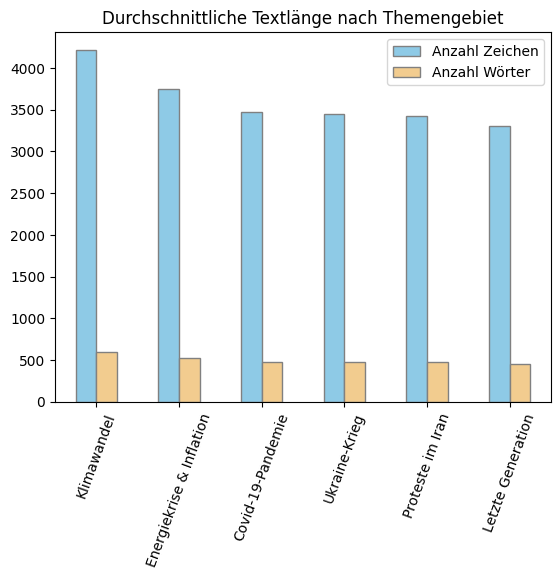

In [13]:
fig, ax1 = plt.subplots()

df.plot(ax=ax1, kind="bar", y=['content_length', 'content_words'], color=["#8ecae6", "#f2cc8f"], edgecolor=["grey"], rot=70)

ax1.set_title('Durchschnittliche Textlänge nach Themengebiet')
ax1.legend(["Anzahl Zeichen", "Anzahl Wörter"])
ax1.xaxis.label.set_visible(False)

ax1.get_figure().savefig('figures/bar-length-topic.png', bbox_inches="tight")

plt.show()